# Avellaneda-Stoikov

In [1]:
import sys
#sys.path.append("/home/paps/Documents/github/DRL4AMM/") # my version of this notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from stable_baselines3 import A2C, PPO, TD3
import stable_baselines3

from DRL4AMM.agents.Agent import Agent
from DRL4AMM.agents.AvellanedaStoikovAgent import AvellanedaStoikovAgent
from DRL4AMM.agents.BaselineAgents import RandomAgent, FixedActionAgent, FixedSpreadAgent
from DRL4AMM.gym.MarketMakingEnvironment import MarketMakingEnvironment
from DRL4AMM.gym.models import *
from DRL4AMM.gym.helpers.generate_trajectory import generate_trajectory
from DRL4AMM.gym.helpers.plotting import *
from DRL4AMM.rewards.RewardFunctions import InventoryAdjustedPnL

## Random strategy

In [2]:
as_env = MarketMakingEnvironment()
terminal_time = as_env.terminal_time
n_steps = as_env.n_steps
timestamps = np.linspace(0, terminal_time, n_steps + 1)

In [3]:
random = RandomAgent(as_env.action_space)

In [4]:
observations, actions, rewards = generate_trajectory(as_env,random)

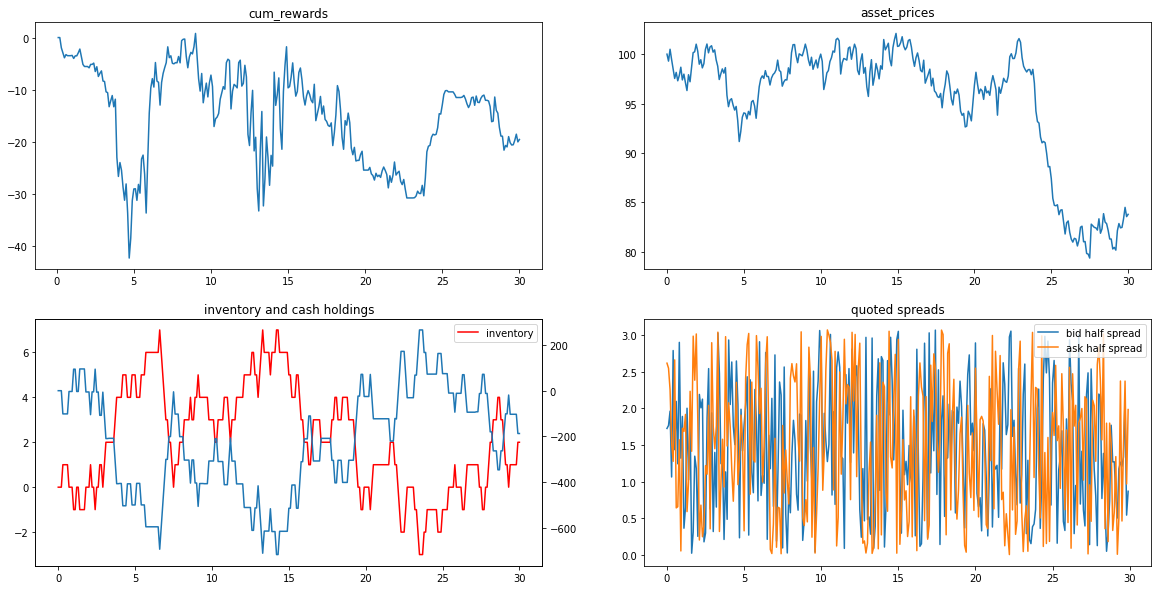

In [5]:
plot_trajectory(as_env, random)

## Fixed strategies

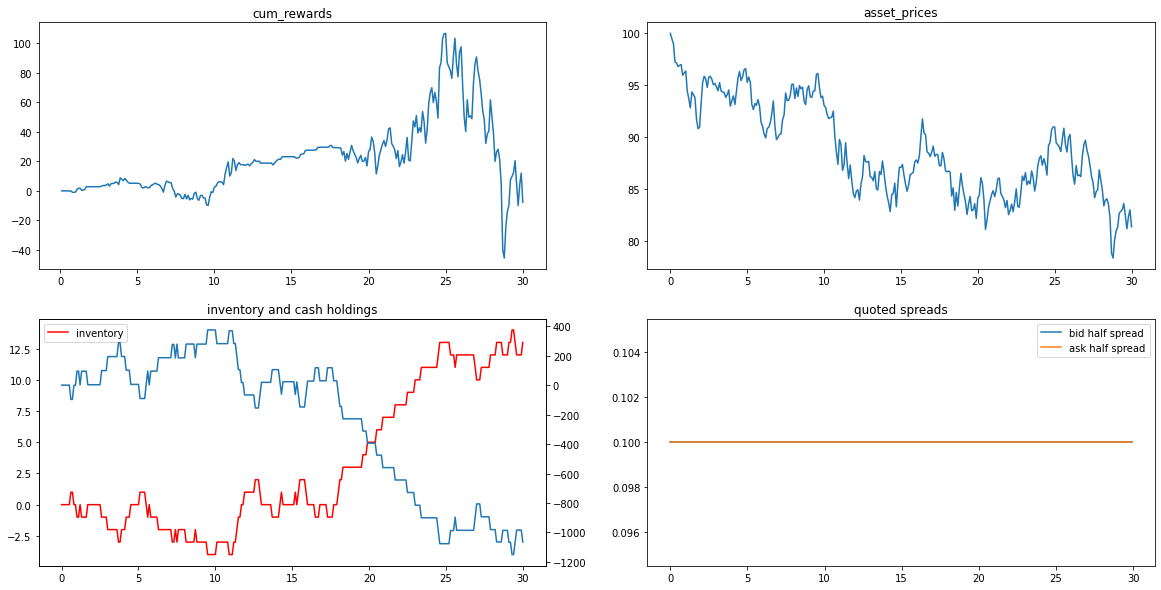

In [6]:
agent = FixedActionAgent(np.array([0.1,0.1]))
plot_trajectory(as_env,agent)

In [7]:
half_spreads = [0.25,0.5,1,2,4]

In [8]:
performance_dict = {}

for hs in half_spreads:
    np.random.seed(42)
    agent = FixedSpreadAgent(half_spread=hs)
    performance_dict[hs] = {}
    performance_dict[hs]["observations"], performance_dict[hs]["actions"], rewards = generate_trajectory(as_env,agent)
    performance_dict[hs]["cum_rewards"] = np.cumsum(rewards)

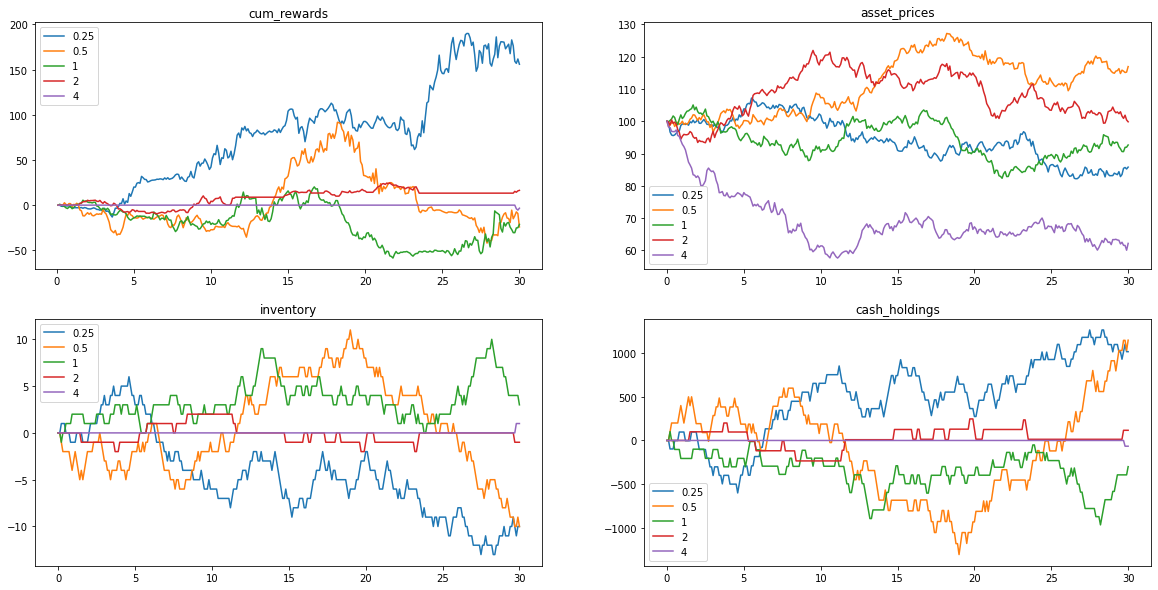

In [9]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))

ax1.title.set_text("cum_rewards")
ax2.title.set_text("asset_prices")
ax3.title.set_text("inventory")
ax4.title.set_text("cash_holdings")

for hs in half_spreads:
    ax1.plot(timestamps[1:],performance_dict[hs]["cum_rewards"], label = hs)
    ax2.plot(timestamps,performance_dict[hs]["observations"][:,3], label = hs)
    ax3.plot(timestamps,performance_dict[hs]["observations"][:,1], label = hs)
    ax4.plot(timestamps,performance_dict[hs]["observations"][:,0], label = hs)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

# TODO: Rewrite AS Agent and get me working. Question: can we write a CarteaJaimungalAgent, which produces for a given CJCriterion. 

## Avellaneda-Stoikov Optimal Strategy

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
as_agent = AvellanedaStoikovAgent()

In [5]:
as_agent.volatility, as_agent.rate_of_arrival, as_agent.fill_exponent, as_agent.risk_aversion

(2.0, array([140., 140.]), 1.5, 0.1)

In [18]:
as_agent._get_action(6,0.99)

array([0.67138521, 0.62338521])

In [7]:
observations, actions, rewards = generate_trajectory(as_env,as_agent)

/Users/leandro_1/Documents/GitHub/deep-reinforcement-learning-for-analytical-market-making/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


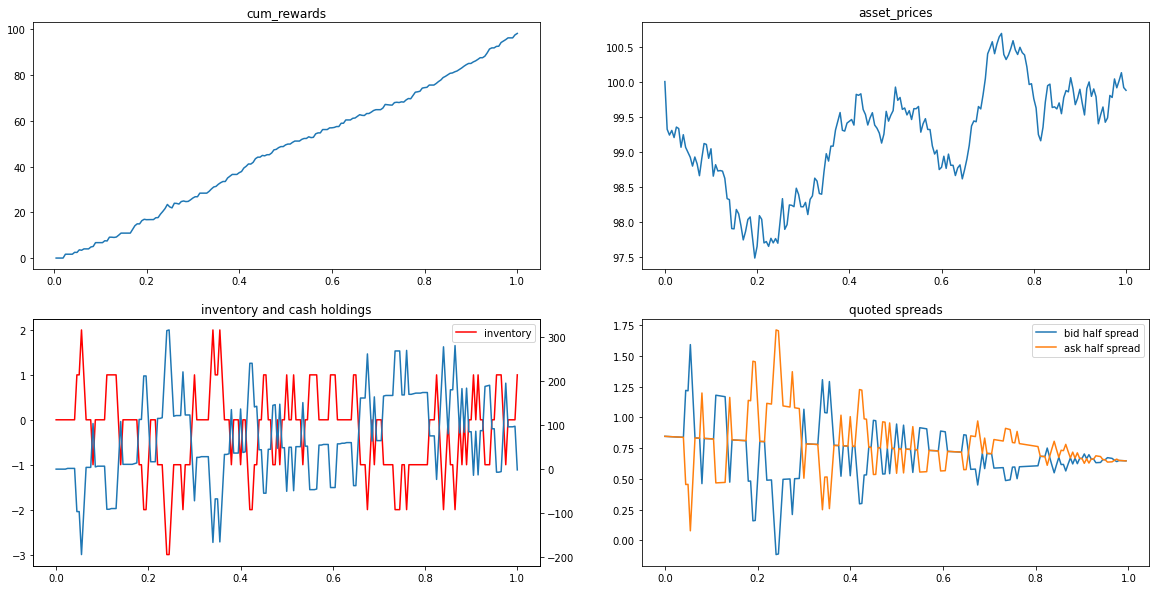

In [8]:
plot_trajectory(as_env,as_agent, seed=42)

### Comparing the results to the Avellaneda Stoikov paper

In [9]:
results, fig, _ = generate_results_table_and_hist(agent=as_agent,env=as_env,n_episodes=1_000)

/Users/leandro_1/Documents/GitHub/deep-reinforcement-learning-for-analytical-market-making/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


In [10]:
results

,Mean spread,Mean PnL,Std PnL,Mean terminal inventory,Std terminal inventory
Inventory,1.49177,93.216593,7.677344,1.0,0.0


These results look similar to Table 2 of Avellaneda and Stoikov. It is interesting that the agent **does** quote a negative spread sometimes, which could be interpreted as taking liquidity but then the model should possibly be changed.

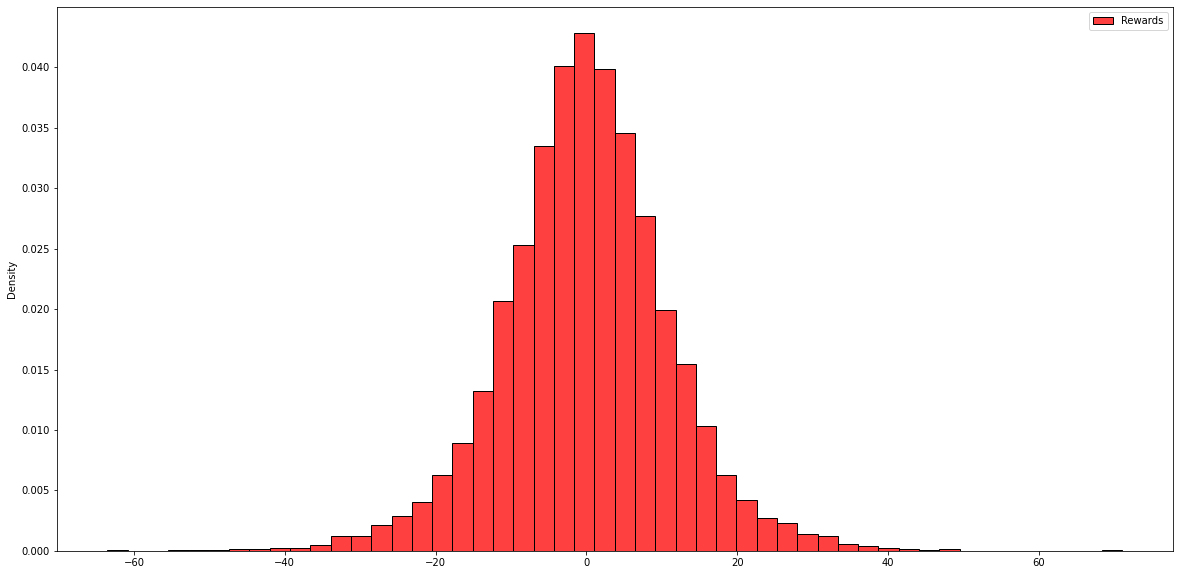

In [27]:
fig

## The effect of increasing risk aversion

In [75]:
risk_aversions = [0.01,0.1,0.5,1]

In [ ]:
total_rewards_dict = dict()
for risk_aversion in risk_aversions:
    agent = AvellanedaStoikovAgent(risk_aversion=risk_aversion)
    _,_,total_rewards_dict[risk_aversion] = generate_results_table_and_hist(agent=agent,env=as_env,n_episodes=1000);   

/home/paps/Documents/github/DRL4AMM/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")
/home/paps/Documents/github/DRL4AMM/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")
/home/paps/Documents/github/DRL4AMM/DRL4AMM/agents/AvellanedaStoikovAgent.py:26: UserWarning: Avellaneda-Stoikov agent is quoting a negative spread
  warnings.warn("Avellaneda-Stoikov agent is quoting a negative spread")


In [ ]:
colors = ["r", "g", "b", "c"]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
for risk_aversion, color in zip(risk_aversions,colors):
    sns.histplot(total_rewards_dict[risk_aversion], label=f"risk-aversion {risk_aversion}", stat = "density", bins = 50, ax=ax, color=color)
ax.legend()
plt.show()

**Note, it is hard to argue that the risk-averse agent is outperforming the non risk-averse agent in these cases...**

### Training a stable baselines agent on the Avellaneda-Stoikov gym environment

See separate notebook.